## Code : PPO Agent
The following code can be find in the `ppo_farm1.py` in `examples/` folder.

### Imports:

In [1]:
from rlberry.agents.torch import PPOAgent
from rlberry.manager import AgentManager, evaluate_agents, plot_writer_data
from rlberry_farms import Farm1
from rlberry.agents.torch.utils.training import model_factory_from_env
import numpy as np
import pandas as pd
import seaborn as sns

/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Settings :
We'll use the `Farm1` environment

In [2]:
env_ctor, env_kwargs = Farm1, {}

We use an architecture of $256\times 256$ for both the value and policy neural network of ppo.
Remark : to enable tensorboard on the farm (to see the internal variable of the farm that are not visible to the agent), we could have used 
```python
env_ctor, env_kwargs = Farm1,{"enable_tensorboard": True, "output_dir": "ppo1_results"}
```

In [3]:

policy_configs = {
    "type": "MultiLayerPerceptron",  # A network architecture
    "layer_sizes": (256, 256),  # Network dimensions
    "reshape": False,
    "is_policy": True,
}

value_configs = {
    "type": "MultiLayerPerceptron",
    "layer_sizes": (256, 256),
    "reshape": False,
    "out_size": 1,
}

### Agent code:
We use rlberry's [PPOAgent](https://rlberry.readthedocs.io/en/latest/generated/rlberry.agents.torch.PPOAgent.html#rlberry.agents.torch.PPOAgent). 
Remark that 365 days is the maximum lenght of an episode. This helps us to fix some of the parameters.

In [12]:
manager = AgentManager(
        PPOAgent,
        (env_ctor, env_kwargs),
        agent_name="PPOAgent",
        init_kwargs=dict(
            policy_net_fn=model_factory_from_env,
            policy_net_kwargs=policy_configs,
            value_net_fn=model_factory_from_env,
            value_net_kwargs=value_configs,
            learning_rate=9e-5,
            n_steps=5 * 365,
            batch_size=365,
            eps_clip=0.2,
        ),
        fit_budget=5e5,
        eval_kwargs=dict(eval_horizon=365),
        n_fit=1,
        output_dir="ppo1_results", # results/trained agents are kept in this directory
    )
manager.fit()

[INFO] 15:03: Running AgentManager fit() for PPOAgent with n_fit = 1 and max_workers = None. 
/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(
/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(
[INFO] 15:03: [PPOAgent[worker: 0]] | max_global_step = 1971 | episode_rewards = -104.0 | total_episodes = 22 | fit/surrogate_loss = -19.57242202758789 | fit/entropy_loss = 1.2079650163650513 | 

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

### Training reward curve

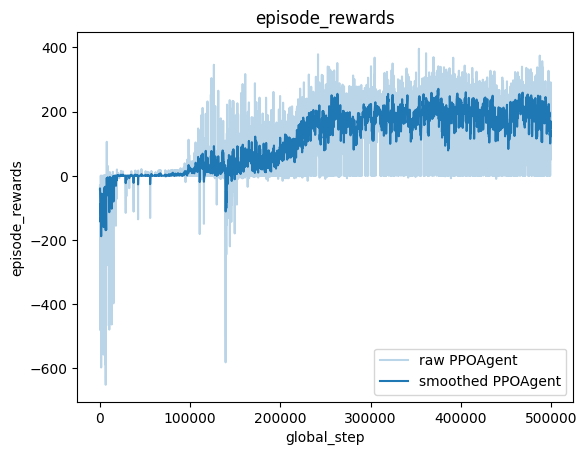

In [18]:
data = plot_writer_data(manager, tag="episode_rewards", smooth_weight=0.8) # smoothing tensorboard-style

### Evaluation of the trained agent

In [19]:
evaluation = evaluate_agents([manager], n_simulations=128, plot=False)
evaluation.describe()

[INFO] 15:22: Evaluating PPOAgent... 
[INFO] Evaluation:................................................................................................................................  Evaluation finished 


,PPOAgent
count,128.000000
mean,167.533772
std,31.468684
min,89.150279
25%,147.731616
50%,170.626595
75%,188.514045
max,254.114489


### Small peek into the agents policy

In [21]:
agent = manager.agent_handlers[0] # select the agent from the manager

In [24]:
env = Farm1()
obs = env.reset()

actions_txt = ["doing nothing", 
           "1L of water", 
           "5L of water", 
           "harvesting",
           "sow some seeds",
           "scatter fertilizer",
           "scatter herbicide",
           "scatter pesticide",
           "remove weeds by hand",]
episode = pd.DataFrame()
for day in range(365):
    action = agent.policy(obs)    
    print("Day: {}, Mean temp: {}, stage: {}, weight of  fruit: {}".format(obs[0], np.round(obs[1],3), 
                                                                           int(obs[7]), obs[15]))
    obs,reward, is_done,_ =  env.step(action)
    print("Action is", actions_txt[action])
    episode = pd.concat([episode, pd.DataFrame({'action':[actions_txt[action]],
                                                'reward':[reward]})], ignore_index=True)
    print('')
    if is_done:
        print('Plant is Dead')
        break

/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/frost/code/rlberry-farms/virtual_env/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(


Day: 1.0, Mean temp: 4.939, stage: 0, weight of  fruit: 0.0
Action is sow some seeds

Day: 2.0, Mean temp: 7.94, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 3.0, Mean temp: 4.929, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 4.0, Mean temp: 6.415, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 5.0, Mean temp: 5.47, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 6.0, Mean temp: 6.813, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 7.0, Mean temp: 11.389, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 8.0, Mean temp: 11.926, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 9.0, Mean temp: 6.926, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 10.0, Mean temp: 5.888, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 11.0, Mean temp: 7.129, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 12.0, Mean temp: 7.57, stage: 1, weight of  fru

<Figure size 1200x900 with 0 Axes>

<AxesSubplot:xlabel='action', ylabel='count'>

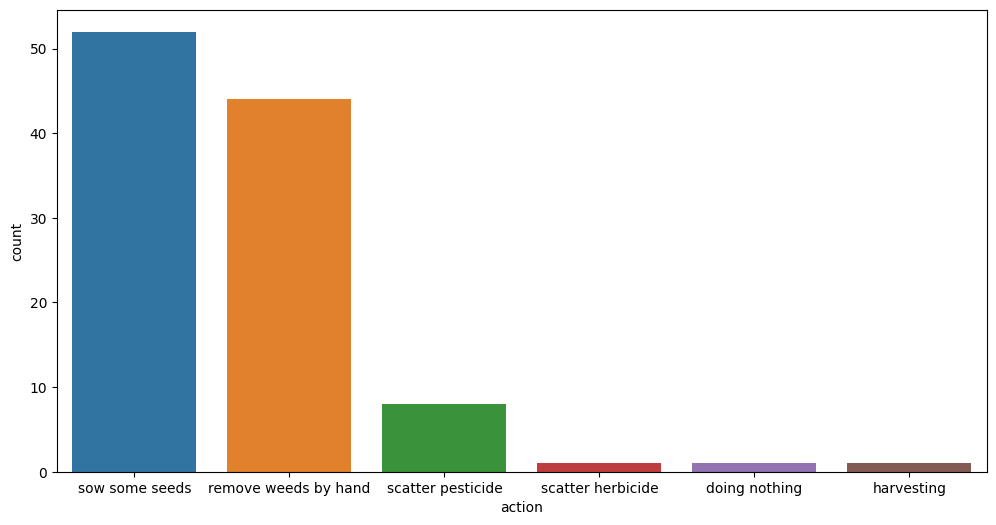

In [26]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(data = episode, x = "action")

From this, we see that in fact it did not learn when to plant and when to harvest yet. But it learned that pesticide destroy the soil very quicly and should be avoided.